Выделение главных компонентов
1. Стандартизация данных
2. Построение ковариационной матрицы
3. Получение собственных значений и собственных векторов ковариационной матрицы
4. Сортировка собственных значений в порядке убывания для ранжирования собственных векторов 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [6]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [7]:
X,y = data.iloc[:, 1:].values, data.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


In [9]:
sc = StandardScaler()
# Стандартизируем, приведя к единичной дисперсии
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:

# Вычислим ковариационную матрицу
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
# eigen_vals - собственные значения, определяющих величину векторов
# eigen_vecs - собственные вектора(главные компоненты), направления максимальной дисперсии

Так как наша задача состоит в том, чтобы понизить размерность набора данных, сжимая его в новое подпространство признаков, мы выбираем только поднабор собственных векторов(главных компонентов), которые содержат большую часть информации (дисперсию). Так как собственные значения определяют величину собственных векторов, отсортируем собственные значения по убыванию величины.

Но мы заинтересованы только в верхних k собственных векторов, но чтобы выбрать это k, построим график коэффициентов объясненной дисперсии собственных значений.

Коэффициент объясненной дисперсии собственного значения - просто доля собственного значения на общую сумму.

In [ ]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,14),var_exp, alpha=0.5, align='center', label = 'индивидуальная объясненная дисперсия')
plt.step(range(1,14), cum_var_exp, where='mid', label = 'кумулятивная объясненная дисперсия')
plt.ylabel('Коэффициент объясненной дисперсии')
plt.xlabel('Индекс главного компонента')
plt.legend(loc='best')
plt.show()

По графику видно, что на долю лишь одного первого главного компонента приходиться примерно 40% дисперсии. А первые два - 60%

### Трансформация признаков
После успешного разложения ковариационной матрицы на собственные пары, необходимо:

1. Выбор k собственных векторов, которые соответствуют k наибольшим собственным значениям, где k - размерность нового подпространства
2. Построение матрицы проекции W из k наибольших векторов
3. Трансформация исходного, d-мерного входного набора данных X с использованием матрицы проекции W, для получения нового подпространства признаков. 

In [12]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k:k[0], reverse=True)

In [13]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:,np.newaxis]))
# Выбираем первые два собственных вектора, так как на них приходиться 60% дисперсии всех данных
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

In [14]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [16]:
X_train_pca = X_train_std.dot(w)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'lower_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


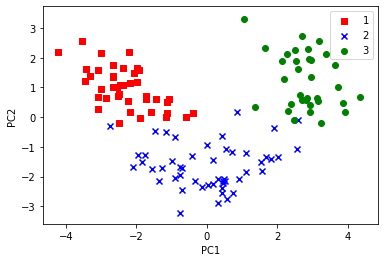

In [18]:
# Визуализируем трансформированный обучающий набор, в виде двумерного графика рассеяния
colors = ['r','b','g']
markers = ['s', 'x', 'o']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],X_train_pca[y_train==l,1],c=c, label=l, marker=m)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower_left')
plt.show()

In [19]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #Настроим генератор маркеров и карту цветов
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Вывести поверхность решения
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max, resolution),np.arange(x2_min,x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl,0], y = X[y == cl, 1], alpha=0.8,c=colors[idx], marker = markers[idx], label=cl, edgecolors='black')
        
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',edgecolor='black',alpha=1.0, linewidths=1, marker='o',s=100, label='Испытательный набор')

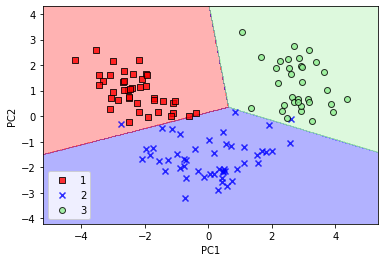

In [20]:
# Рассмотрим реализацию PCA из sklearn
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

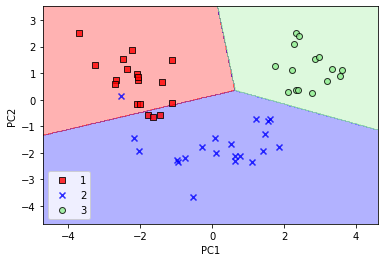

In [22]:
plot_decision_regions(X_test_pca,y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()